<a href="https://colab.research.google.com/github/khangsheng1/PyTorch-Tutorial/blob/main/PyTorch_Tutorial_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

print(training_data)

print(test_data)

100%|██████████| 26421880/26421880 [00:02<00:00, 12578329.47it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 209445.19it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3932169.00it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 23019485.07it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [7]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [8]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.307170  [   64/60000]
loss: 0.569154  [ 6464/60000]
loss: 0.403498  [12864/60000]
loss: 0.505041  [19264/60000]
loss: 0.457565  [25664/60000]
loss: 0.425298  [32064/60000]
loss: 0.371511  [38464/60000]
loss: 0.514534  [44864/60000]
loss: 0.497483  [51264/60000]
loss: 0.538409  [57664/60000]
Test Error: 
 Accuracy: 84.3%, Avg loss: 0.428491 

Epoch 2
-------------------------------
loss: 0.268341  [   64/60000]
loss: 0.356461  [ 6464/60000]
loss: 0.291254  [12864/60000]
loss: 0.400582  [19264/60000]
loss: 0.397514  [25664/60000]
loss: 0.394574  [32064/60000]
loss: 0.299308  [38464/60000]
loss: 0.472998  [44864/60000]
loss: 0.397832  [51264/60000]
loss: 0.468783  [57664/60000]
Test Error: 
 Accuracy: 85.3%, Avg loss: 0.395010 

Epoch 3
-------------------------------
loss: 0.234886  [   64/60000]
loss: 0.330691  [ 6464/60000]
loss: 0.233859  [12864/60000]
loss: 0.332013  [19264/60000]
loss: 0.436725  [25664/60000]
loss: 0.367074  [32064/600

In [9]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [10]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

In [11]:
len(test_data)

10000

We are testing #1433 out of 10000 from the FashionMNIST dataset:
We are testing #7905 out of 10000 from the FashionMNIST dataset:
We are testing #4653 out of 10000 from the FashionMNIST dataset:
We are testing #4462 out of 10000 from the FashionMNIST dataset:


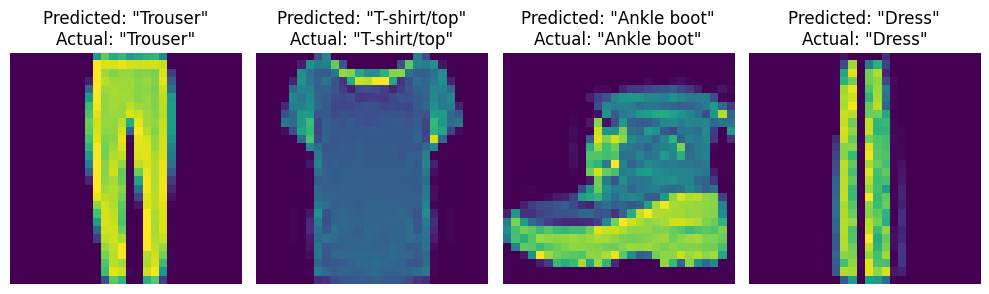

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline


classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

num_iter = 4  # Number of images to test
fig, axs = plt.subplots(1, num_iter, figsize=(10, 3))  # Create subplots (1 row, num_iter columns)

for i in range(num_iter):
    # Generate a random number
    test_num = random.randint(0, 10000)

    model.eval()
    x, y = test_data[test_num][0], test_data[test_num][1]

    # Display image in a subplot
    print(f'We are testing #{test_num} out of 10000 from the FashionMNIST dataset:')
    axs[i].imshow(x.reshape(28, 28))  # Plot in the ith subplot
    axs[i].axis('off')  # Turn off axis for cleaner look

    with torch.no_grad():
        x = x.to(device)
        pred = model(x)
        predicted, actual = classes[pred[0].argmax(0)], classes[y]
        axs[i].set_title(f'Predicted: "{predicted}"\nActual: "{actual}"')  # Set title for the subplot

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

# Get image online

In [42]:
import requests
from PIL import Image
from torchvision import transforms
from io import BytesIO

def load_image_from_url(url):
    # Load the image from URL
    response = requests.get(url, stream=True)  # Use stream=True to avoid loading the entire content into memory
    response.raw.decode_content = True  # Ensure content is decoded
    img = Image.open(BytesIO(response.content))
    # Preprocess the image (resize and convert to tensor)
    preprocess = transforms.Compose([
        transforms.Resize((28, 28)),    # Resize to 28x28 for FashionMNIST
        transforms.ToTensor(),          # Convert to tensor
        transforms.Normalize((0.5,), (0.5,))  # Normalize to match training (if needed)
    ])

    img_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension (1, 1, 28, 28)
    return img_tensor

In [43]:
# URL of the image to classify
image_url = 'https://s3.amazonaws.com/images.ecwid.com/images/23401079/1276317004.jpg'

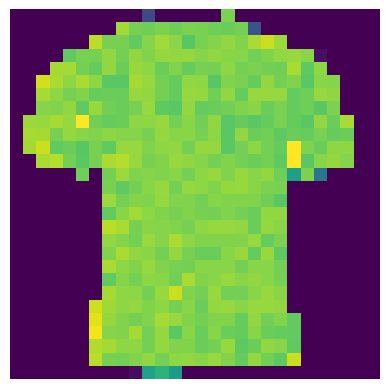

Predicted item: "T-shirt/top"


In [44]:
# Load and preprocess the image
image_tensor = load_image_from_url(image_url)

if image_tensor is not None:
    # Display the image
    plt.imshow(image_tensor.squeeze())
    plt.axis('off')
    plt.show()

    # Evaluate with the model
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)  # Move to the device (GPU/CPU)
        pred = model(image_tensor)
        predicted_class = pred[0].argmax(0).item()

    # Print the prediction result
    print(f'Predicted item: "{classes[predicted_class]}"')
else:
    print("Failed to load the image.")